In [1]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import sklearn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Tensor flow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.python.ops.math_ops import reduce_prod
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding,Dense
import string
import re
## Base Models
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Read Data and Pre-Process

In [4]:
df=pd.read_csv("fake_job_postings.csv")
df.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


### Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

* Remove majority null columns
* Split location

In [6]:
df.drop(columns=['job_id','department','salary_range'], inplace=True)
df_loc=pd.DataFrame(df.location.str.split(",", expand = True))
df['location']=df_loc[0]

In [7]:
df=df.fillna('UNK')
df['full_text'] = df.title+df.company_profile+df.description+df.requirements+df.benefits

## Exploratory Data Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

### Employment Type

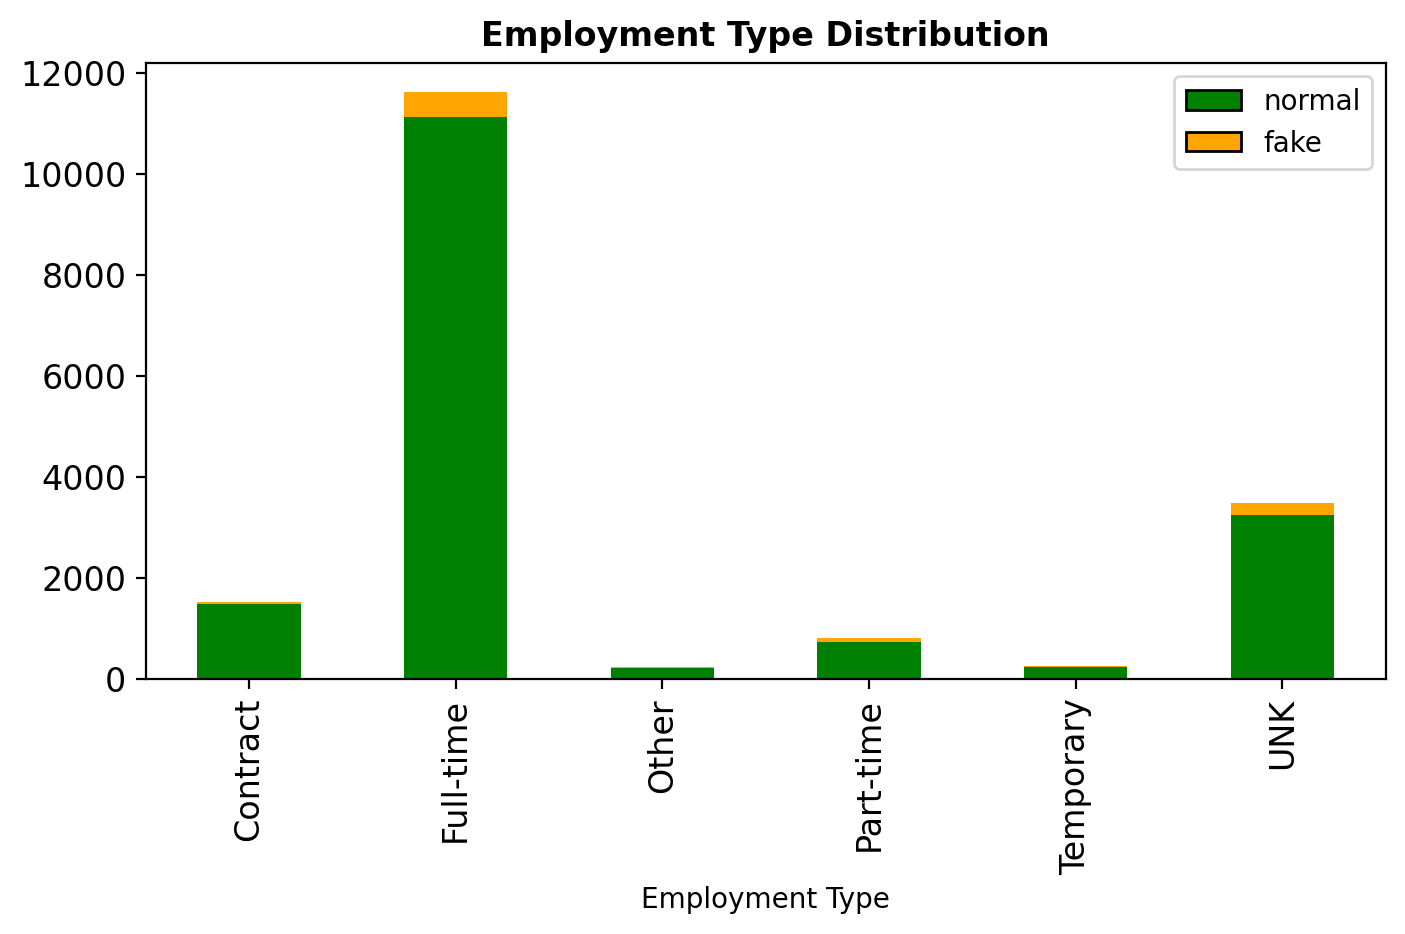

In [9]:
plt.rcParams['figure.figsize'] = (8,4)
pd.crosstab(df['employment_type'], df['fraudulent']).plot(kind='bar', stacked=True,color=['green','orange'])
plt.tick_params(labelsize=12)
plt.title('Employment Type Distribution', fontsize=12,fontweight='bold')

plt.xlabel("Employment Type")
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['green','orange']]
labels= ["normal","fake"]
plt.legend(handles, labels,prop={'size': 10})

### Categorical Binaries

Text(0.5, 1.0, 'telecommuting')

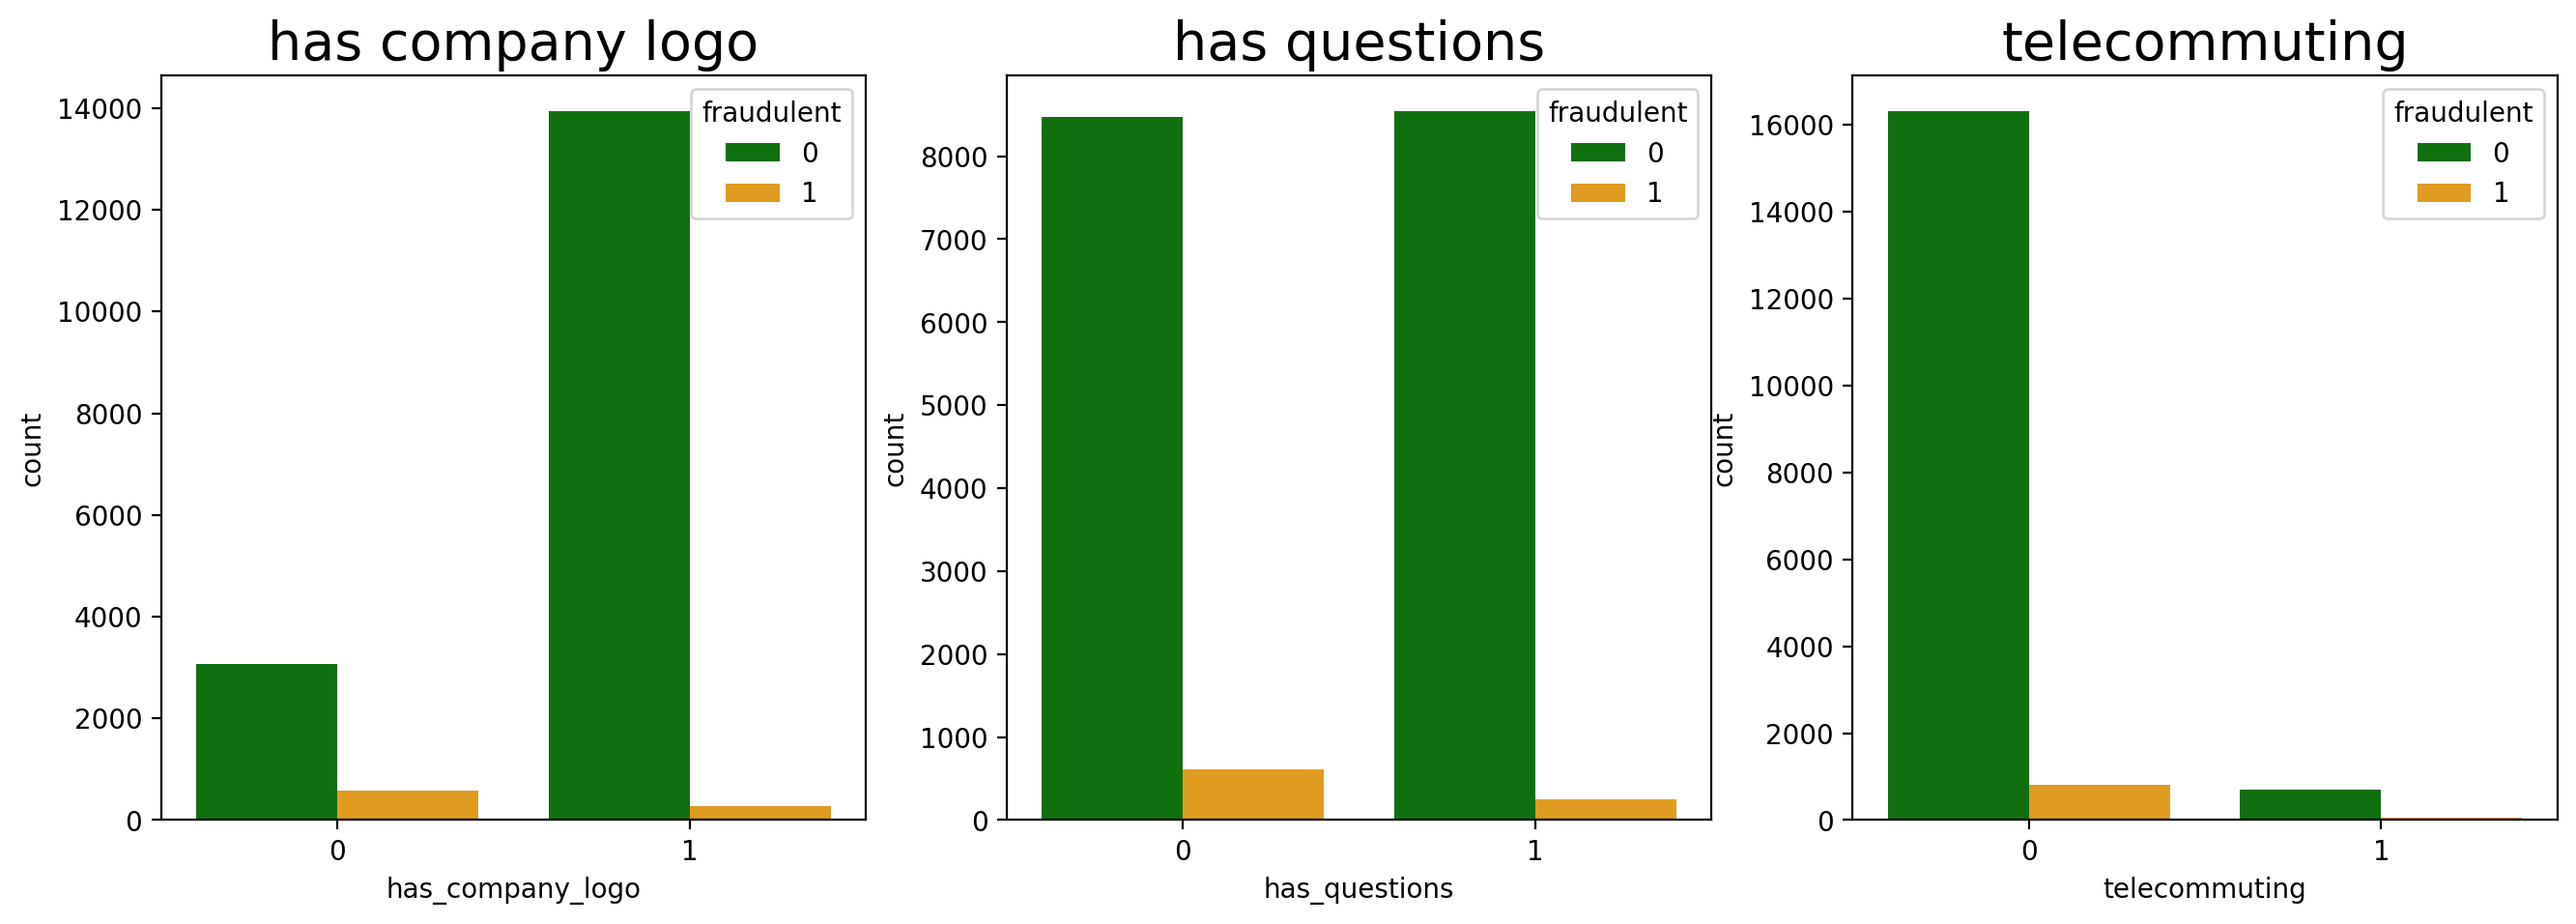

In [10]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.countplot(ax=axes[0],x='has_company_logo', data=df, palette=['green','orange'],hue="fraudulent")
axes[0].set_title("has company logo", fontsize=20)

sns.countplot(ax=axes[1],x='has_questions', data=df, palette=['green','orange'],hue="fraudulent")
axes[1].set_title("has questions", fontsize=20)

sns.countplot(ax=axes[2],x='telecommuting', data=df, palette=['green','orange'],hue="fraudulent")
plt.title("telecommuting", fontsize=20)

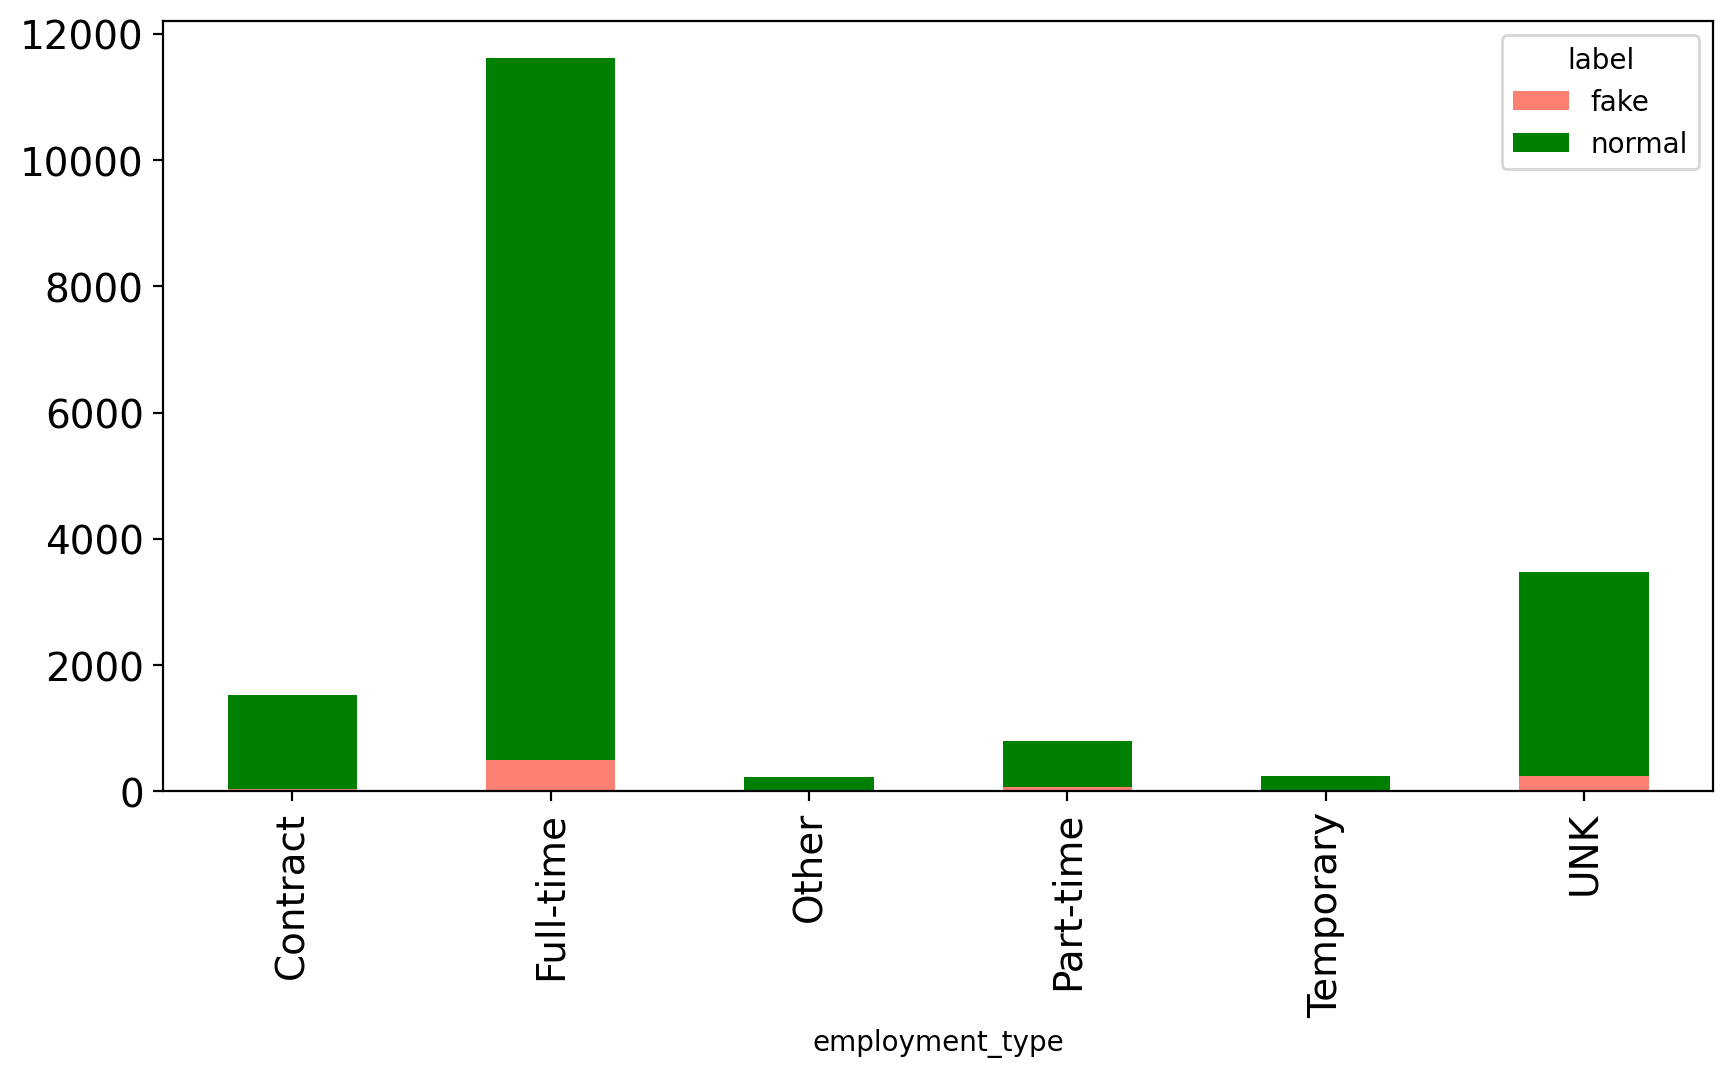

In [11]:
plt.rcParams['figure.figsize'] = (10,5)
df_plot=df[['employment_type', 'fraudulent']]
df_plot['label']=np.where(df_plot.fraudulent==1,'fake','normal')
df_plot=df_plot.groupby(['employment_type', 'label']).size().reset_index().pivot(columns='label', 
                                                                              index='employment_type', values=0)
df_plot.plot(kind='bar', stacked=True,color=['salmon','green'])
plt.tick_params(labelsize=14)

### Word Counts

In [12]:
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.express as px
##
def bar_plot(df, column, title, width, height, n, get_count = True):
    if get_count == True:
        cnt_srs = df[column].value_counts(normalize = True)[:n]
    else:
        cnt_srs = df
        
    trace = go.Bar(
        x = cnt_srs.index,
        y = cnt_srs.values,
        marker = dict(
            color = '#1E90FF',
        ),
    )

    layout = go.Layout(
        title = go.layout.Title(
            text = '<b>'+title+'</b>',
            x = 0.1
        ),
        font = dict(size = 14),
        width = width,
        height = height,
    )

    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig, filename = 'bar_plot')

def count_word_frequency(series,w, top = 0, bot = 20):
    cv = CountVectorizer(stop_words='english')   
    cv_fit = cv.fit_transform(series)    
    word_list = cv.get_feature_names(); 
    count_list = cv_fit.toarray().sum(axis=0)
    frequency = pd.DataFrame({'Word': word_list, 'Frequency': count_list})
    frequency.sort_values(['Frequency'], ascending = False, inplace = True)
    #frequency['Percentage'] = frequency['Frequency']/frequency['Frequency'].sum()
    frequency['Percentage'] = frequency['Frequency'] ##/frequency['Frequency'].sum()
    frequency.drop('Frequency', inplace = True, axis = 1)
    frequency['Percentage'] = frequency['Percentage'].round(3)
    frequency = frequency.iloc[top:bot]
    frequency.set_index('Word', inplace = True)
    bar_plot(pd.Series(frequency['Percentage']), 'Percentage', 'Word Frequency Distribution - '+w, 800, 500, 20, False)
    return frequency
    

## Full text

In [13]:
frequency = count_word_frequency(df['full_text'],'Full text')

## Title word counts

In [14]:
frequency = count_word_frequency(df['title'],'Title')

### Requirements

In [15]:
frequency = count_word_frequency(df['requirements'],"Requirements")

## Company profile

In [16]:
frequency = count_word_frequency(df['company_profile'],"Company profile")

## Benefits

In [17]:
frequency = count_word_frequency(df['benefits'],"Benefits")

## Description

In [18]:
frequency = count_word_frequency(df['description'],'Description')

## Categorical Value handling

In [19]:
df.columns

Index(['title', 'location', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'full_text'],
      dtype='object')

In [20]:
cat_cols=['industry','function','required_education','employment_type','required_experience','location']
df = pd.get_dummies(df, columns=cat_cols) 
print('Shape after one-hot-encoding:',df.shape)
df.head(1) 

Shape after one-hot-encoding: (17880, 299)


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,fraudulent,full_text,...,location_TT,location_TW,location_UA,location_UG,location_UNK,location_US,location_VI,location_VN,location_ZA,location_ZM
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UNK,0,1,0,0,"Marketing InternWe're Food52, and we've create...",...,0,0,0,0,0,1,0,0,0,0


# Modelling

## Vectorization

In [21]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
embedding_dim = 128
sequence_length = 1000

vectorize = TextVectorization(standardize=custom_standardization,
                              max_tokens=max_features,output_mode='int',
                             output_sequence_length=sequence_length,)

In [22]:
vectorize.adapt(df.full_text) 

## Test Train Split

In [23]:
train_val, test = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, 
                                   stratify=df.fraudulent.values)

train, val= train_test_split(train_val, train_size = 0.8, random_state=1, shuffle = True, stratify=train_val.fraudulent.values)
print("train shape:",train.shape)
print('val shape:',val.shape)
print('test shape:',test.shape)

train shape: (11443, 299)
val shape: (2861, 299)
test shape: (3576, 299)


In [24]:
numeric_cols=train.columns
numeric_cols=numeric_cols.drop(['title','company_profile','requirements','full_text',
                               'description','benefits','fraudulent'])

len(numeric_cols)

292

In [25]:
train_full_text = train.full_text
val_full_text = val.full_text
test_full_text = test.full_text

train_title = train.title
val_title = val.title
test_title = test.title

train_requirements = train.requirements
val_requirements = val.requirements
test_requirements = test.requirements

train_description = train.description
val_description = val.description
test_description = test.description

train_company_profile = train.company_profile
val_company_profile = val.company_profile
test_company_profile = test.company_profile

train_benefits = train.benefits
val_benefits = val.benefits
test_benefits = test.benefits

train_numeric = train[numeric_cols].values
val_numeric = val[numeric_cols].values
test_numeric = test[numeric_cols].values

y_train = train.fraudulent
y_val = val.fraudulent
y_test = test.fraudulent


In [26]:
np.array(train[numeric_cols]).shape
vectorize(train_full_text).shape
X_train=np.concatenate((np.array(train[numeric_cols]),vectorize(train_full_text)),axis=1)
X_train.shape

(11443, 1292)

In [27]:
np.array(test[numeric_cols]).shape
vectorize(test_full_text).shape
X_test=np.concatenate((np.array(test[numeric_cols]),vectorize(test_full_text)),axis=1)
X_test.shape

(3576, 1292)

# Base Models

In [28]:
RF = RandomForestClassifier(criterion='gini',n_estimators=500)
GBM = GradientBoostingClassifier(learning_rate=0.01,n_estimators=500)
LGB = LGBMClassifier(learning_rate=0.01,n_estimators=500)

In [29]:
models = [LGB,RF,GBM]
metric_list = []
for m in models:
    mName = type(m).__name__
    m.fit(X_train,y_train)
    
    y_pred = m.predict(X_test)
    
    auroc = np.round(roc_auc_score(y_test, y_pred),4)
    accuracy = np.round(accuracy_score(y_test, y_pred),4)
    precision = np.round(precision_score(y_test, y_pred),4)
    recall = np.round(recall_score(y_test, y_pred),4)
    f1 = np.round(f1_score(y_test, y_pred),4)
    globals()[f"y_pred_{mName}"] = y_pred
    
    
    l = [mName,auroc,accuracy,precision,recall,f1]
    metric_list.append(l)
    print(mName,":",auroc,accuracy,precision,recall,f1)

LGBMClassifier : 0.8313 0.9818 0.9426 0.6647 0.7797
RandomForestClassifier : 0.6991 0.9704 0.9718 0.3988 0.5656
GradientBoostingClassifier : 0.6835 0.9667 0.8649 0.3699 0.5182


In [30]:
df_metric_list = pd.DataFrame(metric_list)
df_metric_list.columns = ['modelName','auroc','accuracy','precision','recall','f1_score']
df_metric_list = df_metric_list.sort_values(["accuracy","auroc"],ascending=False).reset_index(drop=True)
df_metric_list

,modelName,auroc,accuracy,precision,recall,f1_score
0,LGBMClassifier,0.8313,0.9818,0.9426,0.6647,0.7797
1,RandomForestClassifier,0.6991,0.9704,0.9718,0.3988,0.5656
2,GradientBoostingClassifier,0.6835,0.9667,0.8649,0.3699,0.5182


## Confusion matrix

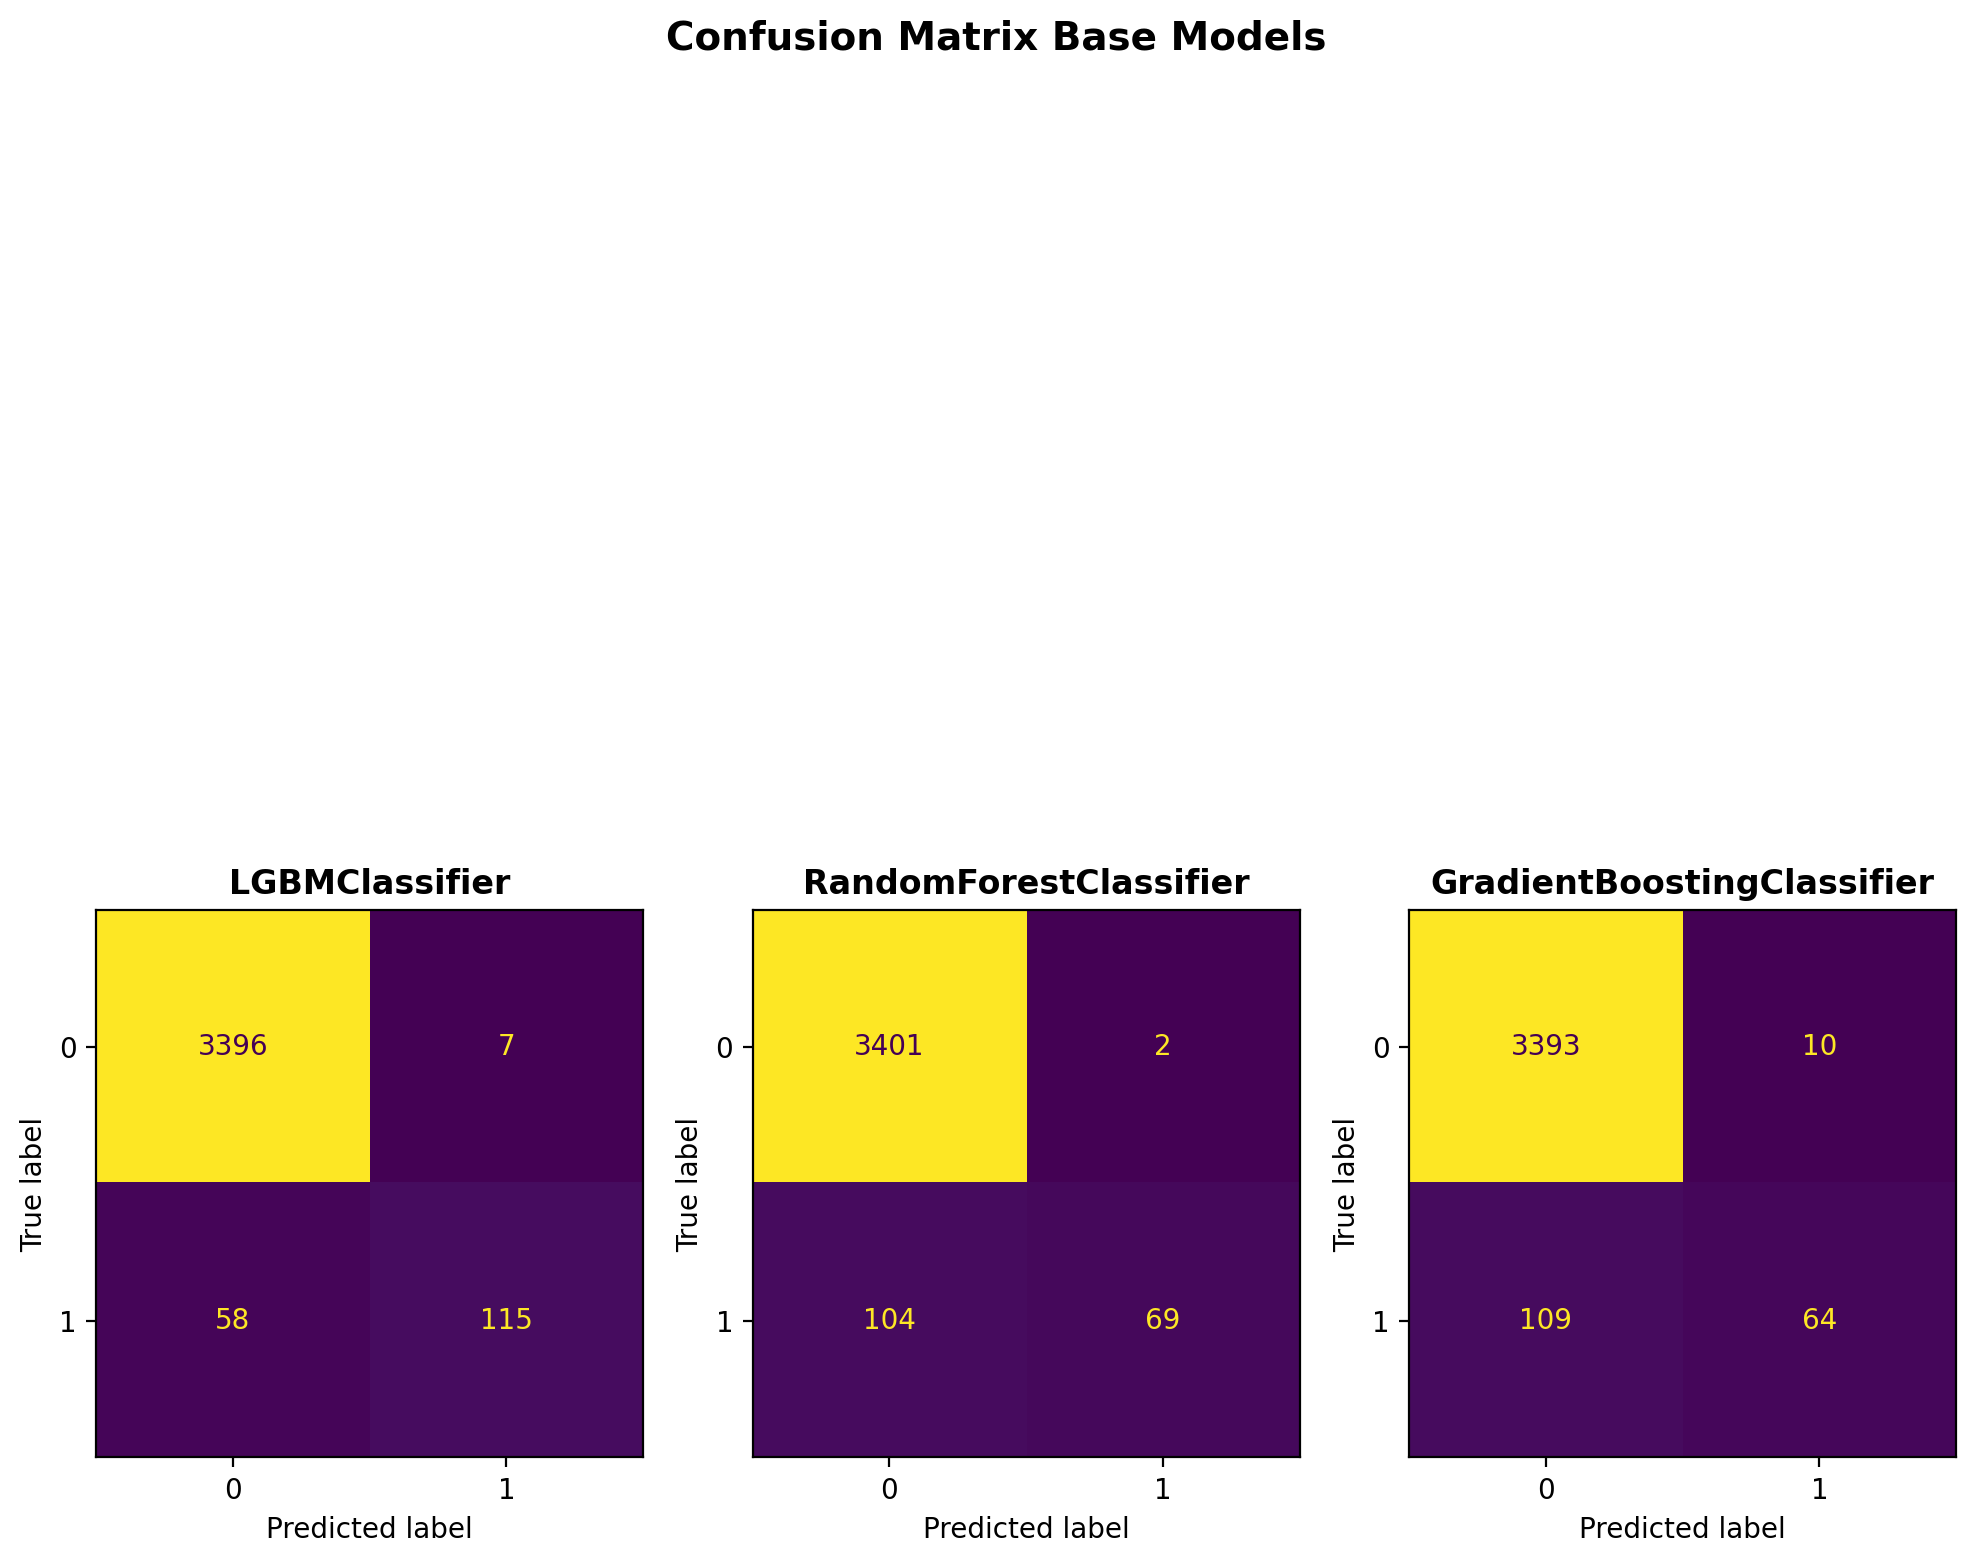

In [31]:
f, axes = plt.subplots(1, 3, figsize=(12,12))
i=0
axes = axes.ravel()
f.suptitle("Confusion Matrix Base Models", fontsize=14, fontweight='bold')
for m in models:
    mName = type(m).__name__
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test,globals()[f"y_pred_{mName}"]))
    disp.plot(ax=axes[i], values_format='.20g')
    axes[i].grid(False)
    disp.ax_.set_title(mName,fontweight='bold',fontsize=12)
    disp.im_.colorbar.remove()
    i=i+1
    
plt.show()  

# Bidirectional LSTM

In [32]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Input

In [33]:
metrics_list = [
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')]

def build_bilstm():

  numeric_inputs = Input(shape=(len(numeric_cols),), name='numeric_inputs')
  num_inp=layers.Dense(128, activation='relu', name='dense_num_1', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=42))(numeric_inputs)
  num_inp=layers.Dropout(0.1)(num_inp)
  num_inp=layers.Dense(128, activation='relu', name='dense_num_2', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=42))(num_inp)

  inputs_title=Input(shape=(1,), dtype=tf.string, name='inputs_title') 
  outputs_title = vectorize(inputs_title)
  a = layers.Embedding(len(vectorize.get_vocabulary()), embedding_dim, input_length=embedding_dim, 
                       name='emb_title',
                       mask_zero=True)(outputs_title)
  a=Bidirectional(LSTM(embedding_dim),name='bidlstm_title')(a)
  
  inputs_company_profile=Input(shape=(1,), dtype=tf.string, name='inputs_company_profile') 
  outputs_company_profile = vectorize(inputs_company_profile)
  b = layers.Embedding(len(vectorize.get_vocabulary()), embedding_dim, 
                       name='emb_company_profile',
                       input_length=embedding_dim, mask_zero=True)(outputs_company_profile)
  b=Bidirectional(LSTM(embedding_dim),name='bidlstm_company_profile')(b)

  inputs_description=Input(shape=(1,), dtype=tf.string, name='inputs_description') 
  outputs_description = vectorize(inputs_description) 
  c = layers.Embedding(len(vectorize.get_vocabulary()), embedding_dim, 
                       name='emb_description',
                       input_length=embedding_dim, mask_zero=True)(outputs_description)
  c=Bidirectional(LSTM(embedding_dim),name='bidlstm_description')(c)

  inputs_benefits=Input(shape=(1,), dtype=tf.string, name='inputs_benefits') 
  outputs_benefits = vectorize(inputs_benefits)
  d = layers.Embedding(len(vectorize.get_vocabulary()), embedding_dim,
                       name='emb_benefits',
                       input_length=embedding_dim, mask_zero=True)(outputs_benefits)
  d=Bidirectional(LSTM(embedding_dim),name='bidlstm_benefits')(d)

  inputs_requirements=Input(shape=(1,), dtype=tf.string, name='inputs_requirements') 
  outputs_requirements = vectorize(inputs_requirements)
  e = layers.Embedding(len(vectorize.get_vocabulary()), embedding_dim, 
                       name='emb_requirements',
                       input_length=embedding_dim, mask_zero=True)(outputs_requirements)
  e=Bidirectional(LSTM(embedding_dim),name='bidlstm_requirements')(e)
  
  inputs = keras.layers.concatenate([num_inp,a,b,c,d,e])
  x = layers.Dense(32, activation='relu', name='dense_1')(inputs)
  output=layers.Dense(1, activation='sigmoid', name='sigmoid_output')(x)

  bilstm_model = Model(inputs=[numeric_inputs,inputs_title,inputs_company_profile,
                            inputs_description,inputs_benefits,inputs_requirements], outputs=[output])
  return bilstm_model

In [34]:
bilstm_model = build_bilstm()
print(bilstm_model.summary())

bilstm_model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = ['accuracy','AUC'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 292)]        0           []                               
                                                                                                  
 inputs_title (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 inputs_company_profile (InputL  [(None, 1)]         0           []                               
 ayer)                                                                                            
                                                                                                  
 inputs_description (InputLayer  [(None, 1)]         0           []                           

In [35]:
#keras.utils.plot_model(bilstm_model)

In [36]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.tf', monitor = 'val_accuracy', 
                     mode = 'max', verbose = 1, save_best_only = True)

In [37]:
del df,train,val,test,train_val
gc.collect()

80418

In [38]:
history = bilstm_model.fit([train_numeric, train_title, train_company_profile,
                         train_description,train_benefits,train_requirements],y_train, 
                        epochs=25, batch_size = 24, 
                        validation_data=([val_numeric, val_title,val_company_profile,
                                          val_description,val_benefits,val_requirements],y_val),
                       verbose = 1, callbacks= [es, mc])

Epoch 1/25
477/477 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9710 - auc: 0.9546
Epoch 1: val_accuracy improved from -inf to 0.98357, saving model to ./model.tf
477/477 [==============================] - 414s 778ms/step - loss: 0.0894 - accuracy: 0.9710 - auc: 0.9546 - val_loss: 0.0556 - val_accuracy: 0.9836 - val_auc: 0.9651
Epoch 2/25
477/477 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9938 - auc: 0.9954
Epoch 2: val_accuracy did not improve from 0.98357
477/477 [==============================] - 140s 294ms/step - loss: 0.0180 - accuracy: 0.9938 - auc: 0.9954 - val_loss: 0.0693 - val_accuracy: 0.9773 - val_auc: 0.9737
Epoch 3/25
477/477 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997 - auc: 1.0000
Epoch 3: val_accuracy did not improve from 0.98357
477/477 [==============================] - 118s 248ms/step - loss: 0.0019 - accuracy: 0.9997 - auc: 1.0000 - val_loss: 0.0736 - val_accuracy: 0.9797 - val

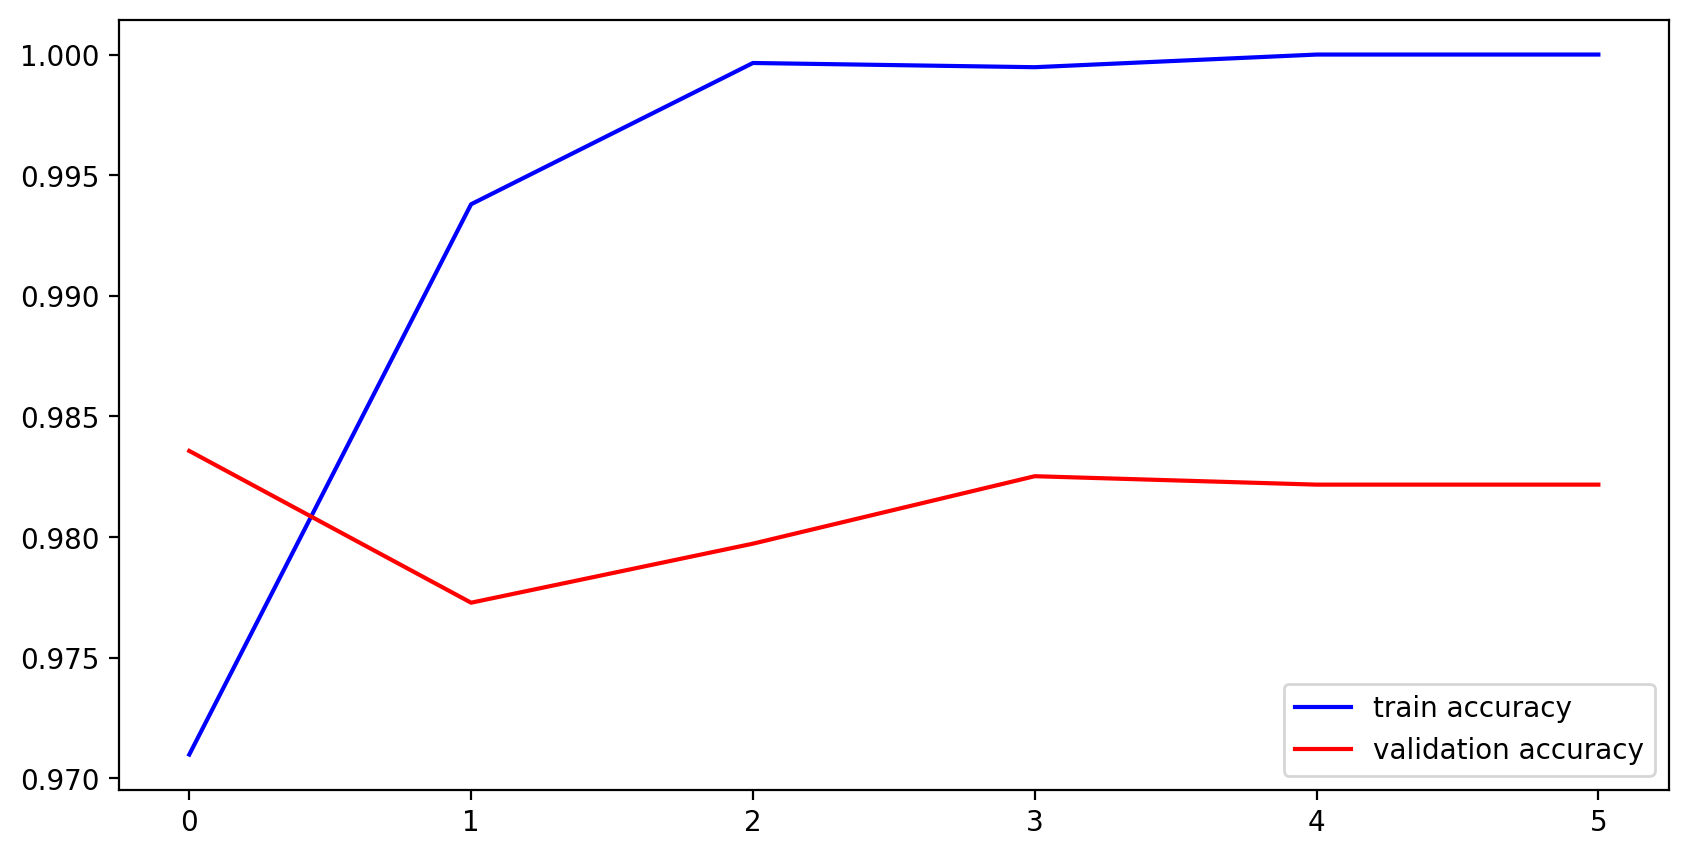

In [39]:
plt.plot(history.history['accuracy'],c='b',label='train accuracy')
plt.plot(history.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

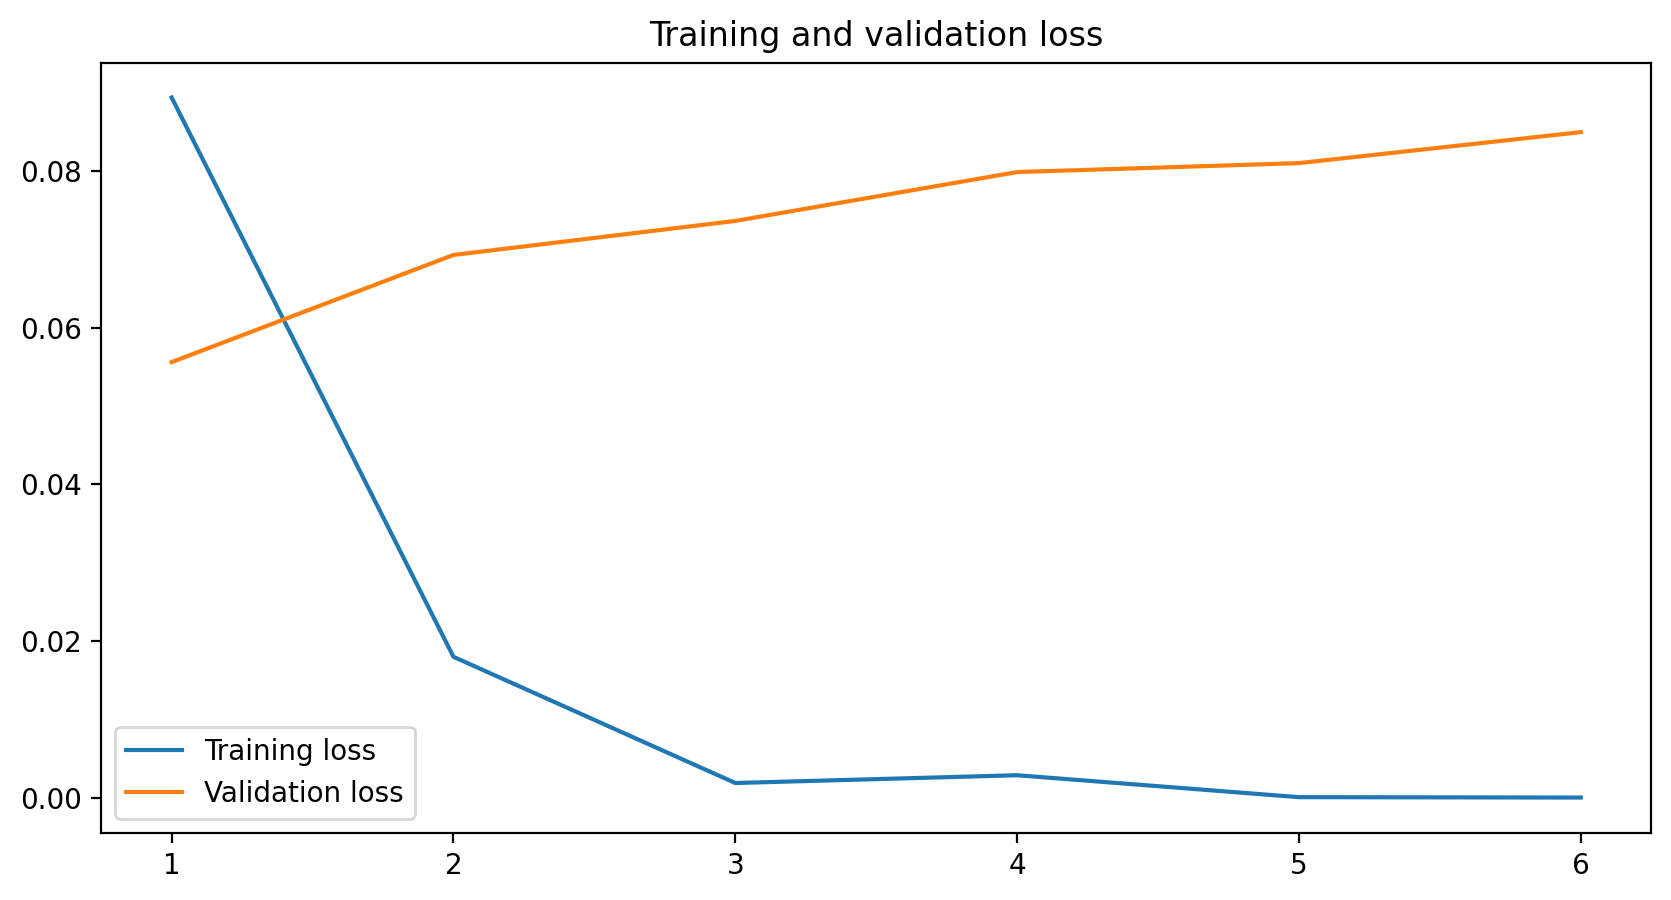

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [41]:
y_pred = bilstm_model.predict([test_numeric,test_title, test_company_profile,test_description,test_benefits,test_requirements])
y_pred=np.where(y_pred>0.5,1,0)

112/112 [==============================] - 19s 70ms/step


In [42]:
confusion_matrix(y_test,y_pred)

array([[3386,   17],
       [  29,  144]])

In [43]:
def getMetrics(y_test,y_pred): 
    auroc = np.round(roc_auc_score(y_test, y_pred),4)
    accuracy = np.round(accuracy_score(y_test, y_pred),4)
    precision = np.round(precision_score(y_test, y_pred),4)
    recall = np.round(recall_score(y_test, y_pred),4)
    f1 = np.round(f1_score(y_test, y_pred),4)
    return auroc,accuracy,precision,recall,f1

In [44]:
df_metric_list = pd.DataFrame([getMetrics(y_test,y_pred)])
df_metric_list.columns = ['auroc','accuracy','precision','recall','f1_score']
df_metric_list

,auroc,accuracy,precision,recall,f1_score
0,0.9137,0.9871,0.8944,0.8324,0.8623


## Confusion Matrix

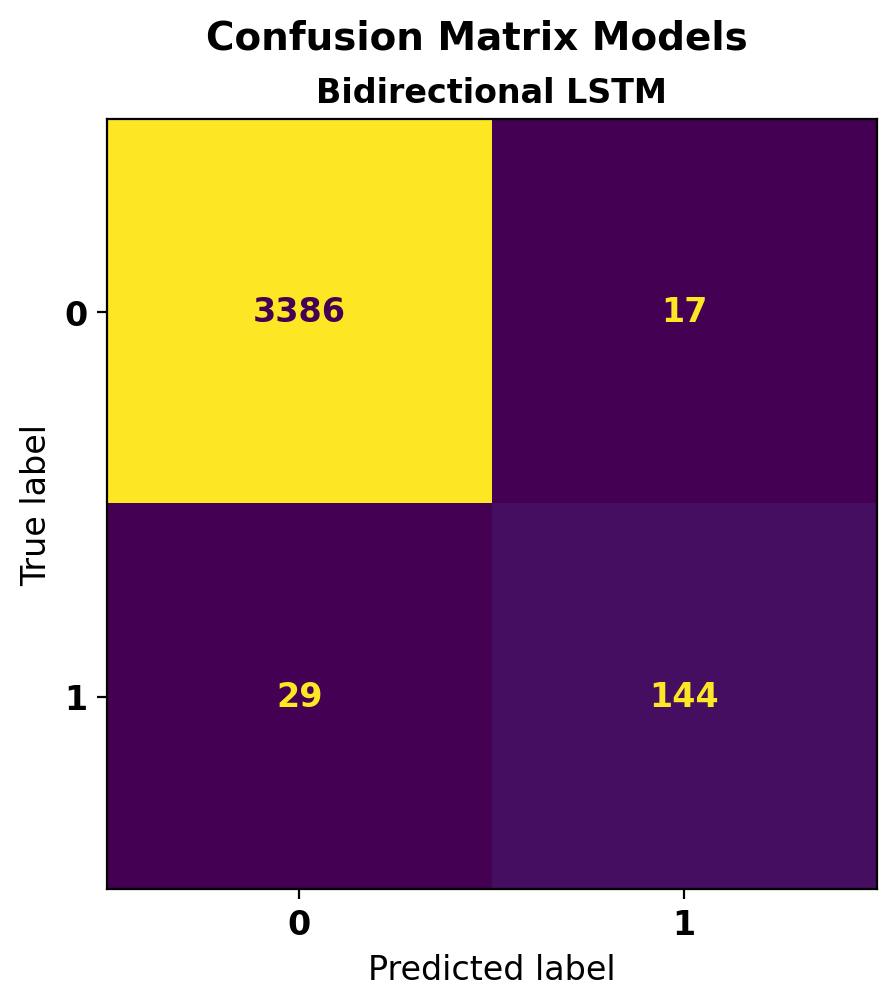

In [45]:
font = {'family':'normal','weight':'bold','size':12}
plt.rc('font', **font)

f, axes = plt.subplots(1, 1, figsize=(5,5))
i=0
#axes = axes.ravel()
f.suptitle("Confusion Matrix Models", fontsize=14, fontweight='bold')
if 1==1:
    mName = 'Bidirectional LSTM'
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
    disp.plot(ax=axes, values_format='.20g')
    axes.grid(False)
    disp.ax_.set_title(mName,fontweight='bold',fontsize=12)
    disp.im_.colorbar.remove()
    i=i+1
    
plt.show()  

## Plot model

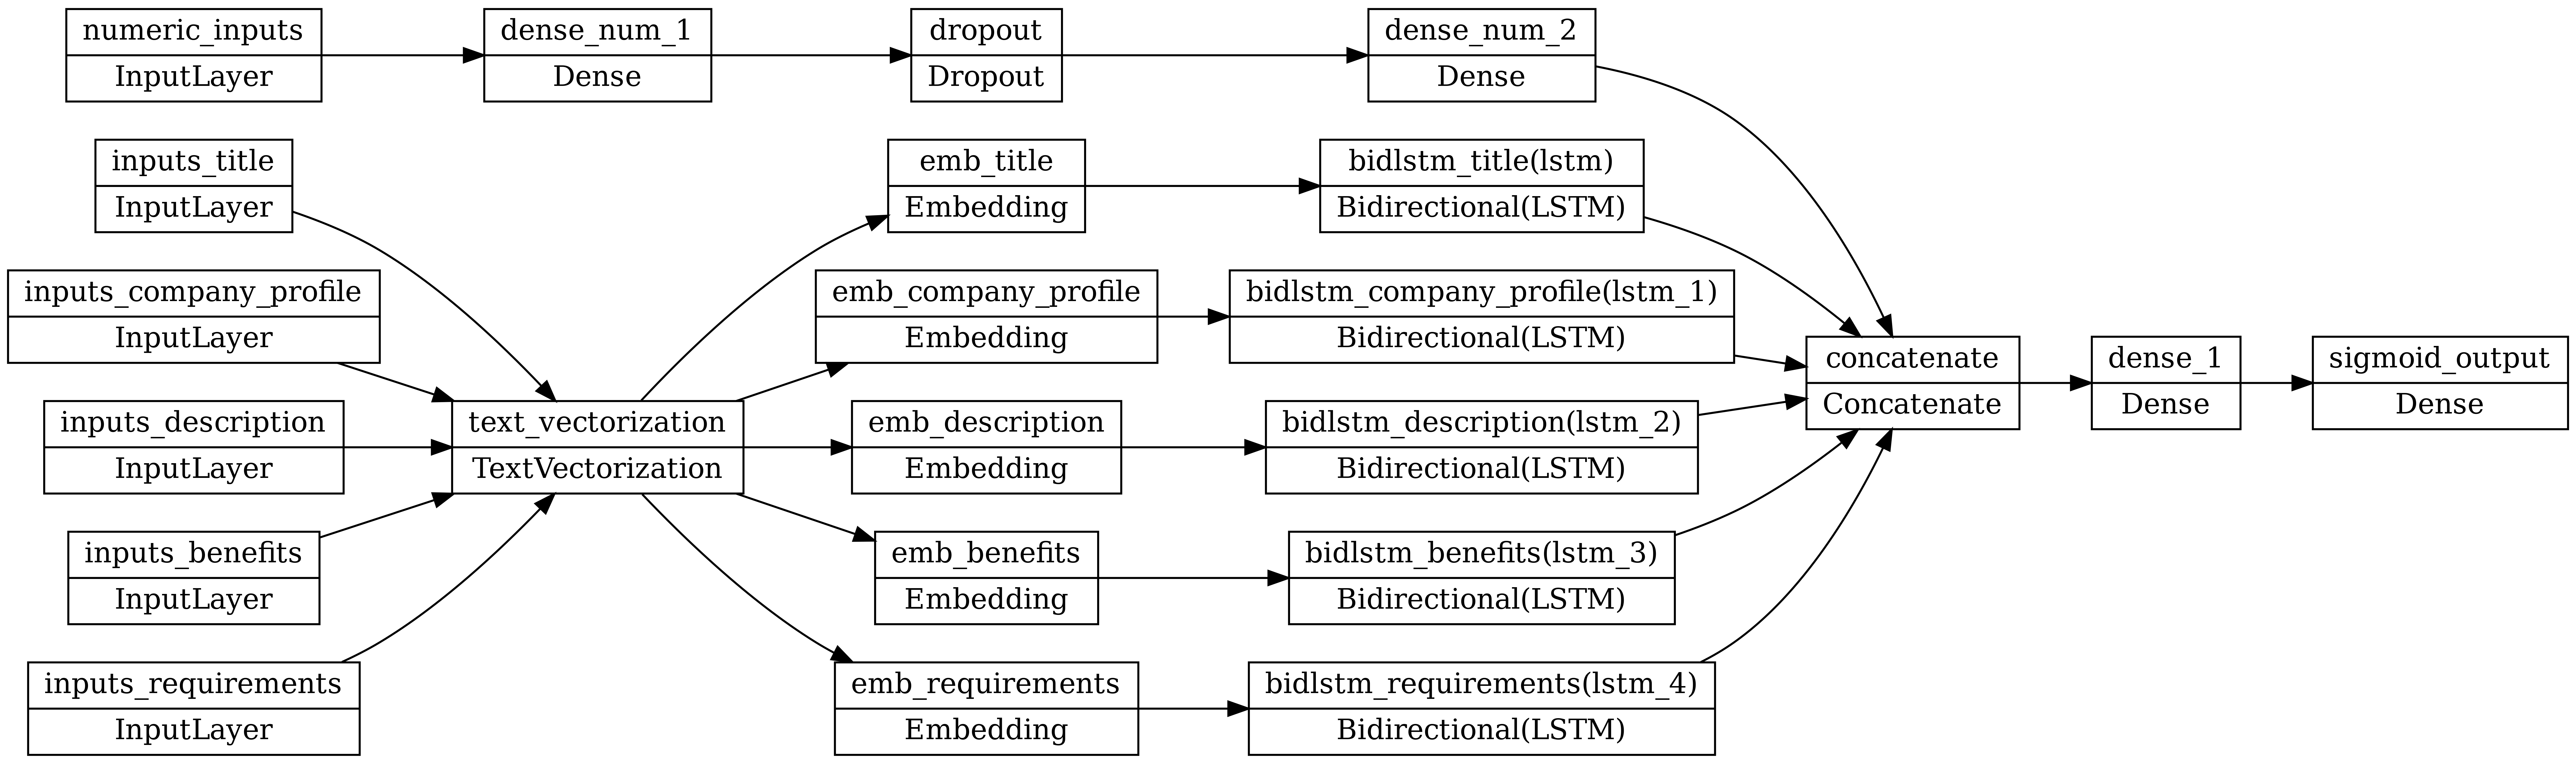

In [46]:
from keras.utils.vis_utils import plot_model

plot_model(
    bilstm_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=600,
    show_layer_activations=False
)